# IMPORTANDO DATASET E BIBLIOTECAS

In [52]:
#Importando bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
#Carregando dataset
df = pd.read_csv(r'C:\Users\felip\OneDrive\Documentos\Projetos Data Science\Estudantes\data\Student_performance_data _.csv')

# 4.LIMPEZA E PRÉ-PROCESSAMENTO DOS DADOS

In [53]:
df.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


Para começar a limpeza, eu irei excluir a coluna, Student ID pois ela tem um valor para cada instância e não ajudaria em nada no modelo, e a coluna Grade Class, pois ela causaria data leakage, visto que ela é completamente derivada da GPA e seria artificial num modelo de predição, pois queremos prever o GPA sem conhecer a nota do aluno.

Além disso, vamos arredondar a variável Study Time, para remover ruído desnecessário e o target, para melhor interpretação.

In [54]:
df.drop(columns=['StudentID', 'GradeClass'], axis=1, inplace=True)

In [55]:
df['GPA'] = df['GPA'].apply(lambda x: round(x,1))
df['StudyTimeWeekly'] = df['StudyTimeWeekly'].apply(lambda x: round(x,1))
df.head()

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA
0,17,1,0,2,19.8,7,1,2,0,0,1,0,2.9
1,18,0,0,1,15.4,0,0,1,0,0,0,0,3.0
2,15,0,2,3,4.2,26,0,2,0,0,0,0,0.1
3,17,1,0,3,10.0,14,0,3,1,0,0,0,2.1
4,17,1,0,2,4.7,17,1,3,0,0,0,0,1.3


Com isso feito, vamos separar os dados em treino e teste.

In [56]:
X = df.drop(columns='GPA', axis=1)
y = df['GPA']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(f'Os dados de treino têm {X_train.shape[0]} linhas, e os dados de teste têm {X_test.shape[0]} linhas')

Os dados de treino têm 1913 linhas, e os dados de teste têm 479 linhas


Para o pré-processamento, dividirei as features em 4 grupos (numéricas, ordinais, categóricas e binárias) para tratamento mais específico de cada feature.

As features binárias não precisarão ser tratadas.

In [73]:
numerical_features = ['Age',
                      'StudyTimeWeekly',
                      'Absences']

categorical_features = ['Gender',
                        'Ethnicity']

binary_features = ['Tutoring',
                   'Extracurricular',
                   'Sports',
                   'Music',
                   'Volunteering']

ordinal_features = ['ParentalEducation',
                    'ParentalSupport']

In [86]:
num_pipe = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ('encoder', OneHotEncoder())
])

ord_pipe = Pipeline(steps=[
    ('encoder', OrdinalEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, numerical_features),
    ('cat', cat_pipe, categorical_features),
    ('ord', ord_pipe, ordinal_features),
    ('bin', 'passthrough', binary_features)
    ])

Farei um loop com alguns modelos de regressão, para decidir qual modelo funciona melhor.

In [87]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree' : DecisionTreeRegressor(),
    'RandomForestRegressor' : RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting' : GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost' : XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM' : LGBMRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "MSE": mse, "R²": r2}
    df_results = pd.DataFrame(results).T
    df_results = df_results.sort_values(by="R²", ascending=False)
print("\nRESULTADOS DOS MODELOS:\n")
print("-" * 50)

for model, scores in results.items():
    print(f"🔹 Modelo: {model}")
    print(f"   - Mean Absolute Error (MAE): {scores['MAE']:.3f}")
    print(f"   - Mean Squared Error (MSE): {scores['MSE']:.3f}")
    print(f"   - R² Score: {scores['R²']:.3f}")
    print("-" * 50)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 1913, number of used features: 16
[LightGBM] [Info] Start training from score 1.900836

RESULTADOS DOS MODELOS:

--------------------------------------------------
🔹 Modelo: LinearRegression
   - Mean Absolute Error (MAE): 0.157
   - Mean Squared Error (MSE): 0.039
   - R² Score: 0.953
--------------------------------------------------
🔹 Modelo: DecisionTree
   - Mean Absolute Error (MAE): 0.268
   - Mean Squared Error (MSE): 0.117
   - R² Score: 0.859
--------------------------------------------------
🔹 Modelo: RandomForestRegressor
   - Mean Absolute Error (MAE): 0.191
   - Mean Squared Error (MSE): 0.061
   - R² Score: 0.927
-----------------------------------------------

O melhor modelo foi o de Regressão Linear simples, o que indica que as nossas variáveis tem uma relação linear com o target.

# 5. MODELAGEM E AVALIAÇÃO DO MODELO

In [88]:
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
    ])
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'StudyTimeWeekly',
                                                   'Absences']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Gender', 'Ethnicity']),
                                                 ('ord',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['ParentalEducation',
                                                   'ParentalSupport']),
                                                 ('bin', 'passthrough',
                                                  ['Tutoring',
                                                   'Extracurricular', 'Sports',
                                                   'Music',
                                                   'Volunteering'])])),
                ('regressor', LinearRegression())])

In [89]:
y_pred = pipe.predict(X_test)

In [90]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae: .2f}")
print(f"MSE = {mse: .2f}")
print(f"RMSE = {rmse: .2f}")
print(f"R² = {r2: .2f}")

MAE =  0.16
MSE =  0.04
RMSE =  0.20
R² =  0.95


Nosso modelo tem um excelente poder preditivo, o erro médio absoluto das previsões dele são de 0.16 e considerando que o GPA varia de 0 a 4, são valores incríveis.

Um RMSE de 0.20, também é um valor interessante, pois mesmo penalizando erros grandes, o erro médio continua pequeno.

E um R² de 95% também é impressionante, pois significa que 95% do target está sendo explicado pelas nossas variáveis.

Para avaliar nosso modelo visualmente, irei plotar um gráfico que compara as predições vs o resultado real dos dados de teste.

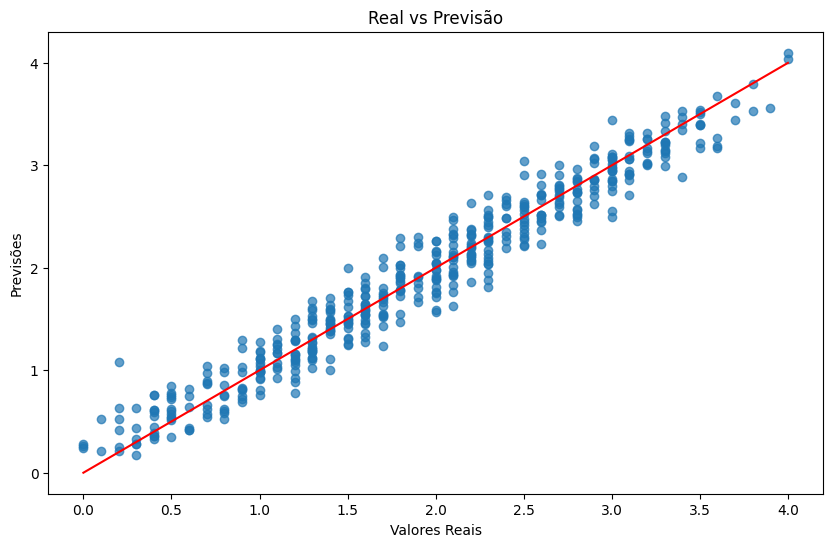

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel("Valores Reais")
plt.ylabel("Previsões")
plt.title("Real vs Previsão")
plt.show()

Interpretação do gráfico:
- A maioria dos pontos se alinha bem com a linha vermelha, o que é um bom resultado.
- Apesar do alinhamento, os pontos tem uma ligeira dispersão vertical, que é ampliada nos valores mais baixos e nos valores mais altos.
- O modelo não tem um padrão de viés evidente, como subestimar ou superestimar os valores, pois ele erra tanto para cima quanto para baixo.
- No final, é um modelo satisfatório que pode ajudar imensamente os responsáveis pela instituição de ensino, a identificar notas ruins ou boas antes mesmo delas acontecerem e aprimorar o desempenho acadêmico geral dos alunos.

 Para finalizar, veremos quais features são mais importantes para a predição e aonde o colégio tem que direcionar seus esforços para uma maior nota dos alunos. Segue a fórmula da regressão linear, para entendermos como faremos isso:

Explicação da fórmula da Regressão linear:

- y é a variável dependente, também chamda de target, e no nosso caso, o GPA.

- β0 é o interceepto, valor de y quando todas as variáveis são 0.

- βn é o coeficiente da n-ésima variável independente (feature), corresponde quanto a variável Xn influencia nosso target.

- e é o resíduo, diferença entre o valor previsto pelo modelo e o valor observado.

Para saber quais features mais impactam o target, iremos checar os coeficientes de cada variável independente do nosso modelo.

In [92]:
feature_names = preprocessor.get_feature_names_out()

print(feature_names)

['num__Age' 'num__StudyTimeWeekly' 'num__Absences' 'cat__Gender_0'
 'cat__Gender_1' 'cat__Ethnicity_0' 'cat__Ethnicity_1' 'cat__Ethnicity_2'
 'cat__Ethnicity_3' 'ord__ParentalEducation' 'ord__ParentalSupport'
 'bin__Tutoring' 'bin__Extracurricular' 'bin__Sports' 'bin__Music'
 'bin__Volunteering']


In [96]:
regressor = pipe.named_steps['regressor']

feature_importances = np.abs(regressor.coef_)

feature_names = preprocessor.get_feature_names_out()

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance':feature_importances
})

feature_importance.sort_values(by='importance', ascending=False)

,feature,importance
2,num__Absences,0.844535
11,bin__Tutoring,0.259839
12,bin__Extracurricular,0.190330
13,bin__Sports,0.186969
1,num__StudyTimeWeekly,0.165479
14,bin__Music,0.154181
10,ord__ParentalSupport,0.147337
15,bin__Volunteering,0.008276
0,num__Age,0.007317
5,cat__Ethnicity_0,0.006842


A feature que mais impacta o target é de fato o número de faltas, como nós suspeitávamos desde a análise exploratória.
A segunda feature que mais impacta o target é tutoring, que é uma variável binária que indica se o aluno teve ou não aulas particulares.

# 6. SOLUÇÃO PARA O PROBLEMA DE NEGÓCIO

Com o nosso modelo preditivo, a escola já consegue identificar o baixo desempenho acadêmico do aluno antes mesmo das notas finais dele. Permitindo criar soluções personalizadas para cada aluno ou comunicar aos pais do respectivo aluno. Também é possível tomar as seguintes soluções preventivas mais generalizadas para aprimorar o desempenho acadêmico médio dos estudantes:

## Soluções para reduzir o número de faltas

Como vimos na nossa última análise, o número de faltas é o fator principal que modifica a nota final do aluno, e para reduzí-lo a fim de aumentar o desempenho final, podemos:
- Implementar um sistema de monitoramento para identificar alunos com alto número de faltas.
- Enviar alertas para os pais e responsáveis quando o número de faltas atingir um certo limite.
- Oferecer suporte psicológico e social para alunos com faltas frequentes, identificando possíveis causas(problemas de saúde, familiares, etc.).
- Criar programas de recompensas para alunos com boa frequência.

## Nível de tutoria

Outro fator que impacta em grande quantitade na nota do aluno é se ele tem ou não tutoria, que eu irei entender como aulas particulares fora da escola. Para ajudarmos os alunos com dificuldade nas matérias a terem um melhor desempenho nas provas, podemos:

- Oferecer sessões com monitores no contraturno das aulas, para os alunos tirarem as dúvidas que tiveram durante as aulas.
- Recomendar professores particulares de confiança para os pais dos alunos contratarem.

## ATIVIDADES EXTRACURRICULARES

Outro fator que influencia positivamente o desempenho escolar do aluno, é se ele está ou não matriculado em atividades extracurriculares, principalmente atividades esportivas e musicais. Tendo isso em mente, podemos:

- Expandir o leque de atividades extracurriculares disponíveis, incluindo esportes, música, teatro, robótica, etc.
- Oferecer horários flexíveis para que os alunos possam participar dessas atividades sem prejudicar o tempo de estudo.
- Criar um sistema que recompense alunos que estiverem matriculados em atividades extracurriculares.